# How to create groups of layers and each one with a different Learning Rate? | fastai v2

## Objective of the notebook

The objective of this notebook is to explain how to create parameters groups for a model with fastai v2 in order to train each one with a different Learning Rate and how to pass the list of Learning Rates.

- Author: Pierre Guillou
- Date: May 2020

## Overview of the results

### Parameters groups

If you want to change the fastai2 default configuration (3 parameters groups), you need to define a ```splitter``` function and pass it to the ```Learner```.

**Example**

```
def splitter(m):
    groups = [group for group in m.children()]
    groups = L(groups)
    return groups.map(params)

learn = Learner(dls, my_model, splitter=splitter, metrics=error_rate)
```

([source](https://dev.fast.ai/learner#Learner)) ```splitter``` is a function that takes ```self.model``` and returns a list of parameter groups (or just one parameter group if there are no different parameter groups). The default is [trainable_params](https://dev.fast.ai/torch_core#trainable_params), which returns all trainable parameters of the model.
```
def trainable_params(m):
    "Return all trainable parameters of `m`"
    return [p for p in m.parameters() if p.requires_grad]
```

### One Learning Rate (max) by parameters group

There are 4 possiblities. 

For example with 3 parameters groups, you can do the following (for a ```Learner``` unfrozen and the use of ```learn.fit_one_cycle()```):

```
1. if lr_max = 1e-3 -> [0.001,0.001,0.001]
2. if lr_max = slice(1e-3) -> [0.0001,0.0001,0.001]
3. if lr_max = slice(1e-5,1e-3) -> array([1.e-05, 1.e-04, 1.e-03]) #LRs evenly geometrically spaced
4. if lr_max = [1e-5, 1e-4, 1e-3] -> array([1.e-05, 1.e-04, 1.e-03]) #LRs evenly linearly spaced or not
```

1. All parameters groups will use **the same Learning Rate** (and the same Optimizer method like Adam + 1cycle policy for all).
2. The last layer group’s Learning Rate (max) value is setup to lr, and all previous parameters groups ones to **lr/10**.
3. Train the very first layers at a Learning Rate of 1e-5, the very last at 1e-3, and the Learning Rates of other parameters groups are **evenly geometrically spaced** between theses two values.
4. Train the very first layers at a Learning Rate of 1e-5, the very last at 1e-3, and the Learning Rates of other parameters groups are **evenly linearly spaced between theses two values or you can pass as a list any Learning Rate values**.

### WARNING

**Points 3 and 4 are not equivalent for a number of parameters groups greater than 3!!!**

- point 3: Learning Rates are calculated geometrically.
- point 4: you can pass an array with the Learning Rate values you want.

Check the following graph to understand what means passing a slice with 2 values as list of Learning Rates (point 3).

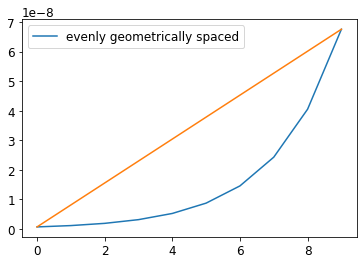

In [1]:
from IPython.display import Image
Image("images/lrs.png")

## Initialization

In [2]:
#hide
from utils import *

In [3]:
print(f'cuda device: {torch.cuda.current_device()}')
print(f'cuda device name: {torch.cuda.get_device_name(0)}')

cuda device: 0
cuda device name: Tesla V100-PCIE-32GB


In [4]:
import warnings
warnings.filterwarnings('ignore')

## fastai documentation

- class [Learner](https://github.com/fastai/fastai2/blob/master/fastai2/learner.py#L81)
  - [defaults.lr](https://github.com/fastai/fastai2/blob/master/fastai2/learner.py#L22) = 1e-3
  - [create_opt()](https://github.com/fastai/fastai2/blob/master/fastai2/learner.py#L140)
  - [fit_one_cycle](https://github.com/fastai/fastai2/blob/master/fastai2/callback/schedule.py#L103)
    - [combined_cos()](https://dev.fast.ai/callback.schedule#combined_cos)
- class [Optimizer](https://github.com/fastai/fastai2/blob/master/fastai2/optimizer.py#L64)
  - [hypers](https://github.com/fastai/fastai2/blob/master/fastai2/optimizer.py#L72)

### combined_cos()

tensor(0.9899) 4.574851048952042e-06
tensor(1.) 9.999999999940612e-08


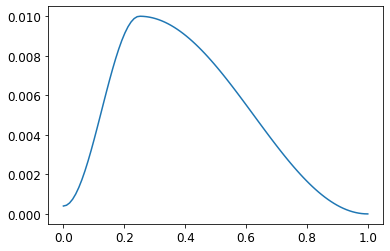

In [5]:
lr_max=1e-2
div=25.
div_final=1e5
pct_start=0.25

p = torch.linspace(0.,1,100)
f = combined_cos(pct_start, lr_max/div, lr_max, lr_max/div_final)
plt.plot(p, [f(o) for o in p]);

# last values of cosine annealing for the 1cycle policy for lr_max = 1e-2
print(p[-2],f(p[-2]))
print(p[-1],f(p[-1]))

## Data

In [6]:
from fastai2.vision.all import *
path = untar_data(URLs.PETS)

In [7]:
#hide
Path.BASE_PATH = path

## Dataloaders

In [8]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

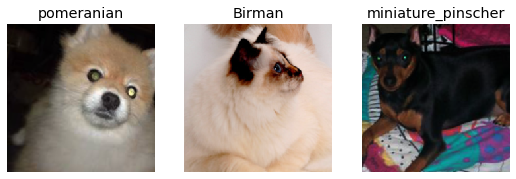

In [9]:
dls.show_batch(nrows=1, ncols=3)

In [10]:
dls.vocab

(#37) ['Abyssinian','Bengal','Birman','Bombay','British_Shorthair','Egyptian_Mau','Maine_Coon','Persian','Ragdoll','Russian_Blue'...]

## Model

Change pretrained resnet18 with an output layer of 1000 classes to 37.

In [11]:
# model resnet18
m = resnet18(pretrained=True)

# last layer of m
# list(m.children())[-1]
m.fc

Linear(in_features=512, out_features=1000, bias=True)

In [12]:
# number of classes of my dls
num_classes = len(dls.vocab)
num_classes

37

In [13]:
# HEAD of the model: remplace last linear layer of 1000 classes by one with 37 classes
# source: https://discuss.pytorch.org/t/resnet-last-layer-modification/33530/2
my_model = m
my_model.fc = nn.Linear(512, num_classes)

# last layer of m
list(my_model.children())[-1]

Linear(in_features=512, out_features=37, bias=True)

## Learner

### Splitter

([source](https://dev.fast.ai/learner#Learner)) ```splitter``` is a function that takes ```self.model``` and returns a list of parameter groups (or just one parameter group if there are no different parameter groups). The default is [trainable_params](https://dev.fast.ai/torch_core#trainable_params), which returns all trainable parameters of the model.
```
def trainable_params(m):
    "Return all trainable parameters of `m`"
    return [p for p in m.parameters() if p.requires_grad]
```

In [14]:
# number of layers groups of my_model
len(list(my_model.children()))

10

Therefore, if we don't pass a splitter function to our ```Learner```, only one Learning Rate will be applied to all layers of my_model. 

As there are 10 layers groups in my_model, let's create a ```splitter``` function that distributes the parameters of my_model to 10 parameters groups.

In [15]:
def splitter(m):
    groups = [group for group in m.children()]
    groups = L(groups)
    return groups.map(params)

In [16]:
# number of parameters groups of my_model
len(splitter(my_model))

10

#### Learner without splitter

Without splitter, there is 1 parameters group by default and therefore, 1 Learning Rate (1e-3 by default).

In [17]:
learn = Learner(dls, my_model, metrics=error_rate)

In [18]:
# Check the number of parameters groups...
learn.create_opt()
print(f'number of parameters groups: {len(learn.opt.param_groups)}')

# ... and the list of Learning Rates (before its atualization by the Optimizer of the function fit_one_cycle())
for i,h in enumerate(learn.opt.hypers):
    print(i,h)

number of parameters groups: 1
0 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}


#### Learner with splitter

With our ```splitter```, there are 10 parameters groups and automatically, the same Learning Rate (1e-3 by default) for each group.

In [19]:
learn = Learner(dls, my_model, splitter=splitter, metrics=error_rate)

In [20]:
# Check the number of parameters groups...
learn.create_opt()
print(f'number of parameters groups: {len(learn.opt.param_groups)}')

# ... and the list of Learning Rates (before its atualization by the Optimizer of the function fit_one_cycle())
for i,h in enumerate(learn.opt.hypers):
    print(i,h)

number of parameters groups: 10
0 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}
1 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}
2 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}
3 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}
4 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}
5 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}
6 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}
7 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}
8 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}
9 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}


## Training with splitter

In [21]:
learn = Learner(dls, my_model, splitter=splitter, metrics=error_rate)
learn.freeze()

In [22]:
learn.summary()

ResNet (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 112 x 112  9,408      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 112 x 112  128        True      
________________________________________________________________
ReLU                 64 x 64 x 112 x 112  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 56 x 56    0          False     
________________________________________________________________
Conv2d               64 x 64 x 56 x 56    36,864     False     
________________________________________________________________
BatchNorm2d          64 x 64 x 56 x 56    128        True      
________________________________________________________________
ReLU                 64 x 64 x 56 x 56    0          False     
_____________________________________________________

**List of Learning Rates before its atualization by the Optimizer of the function fit_one_cycle()**

In [23]:
# Check the number of parameters groups...
learn.create_opt()
print(f'number of parameters groups: {len(learn.opt.param_groups)}')

# ... and the list of Learning Rates (before its atualization by the Optimizer of the function fit_one_cycle())
for i,h in enumerate(learn.opt.hypers):
    print(i,h)

number of parameters groups: 10
0 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}
1 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}
2 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}
3 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}
4 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}
5 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}
6 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}
7 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}
8 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}
9 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}


SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.010964781977236271)

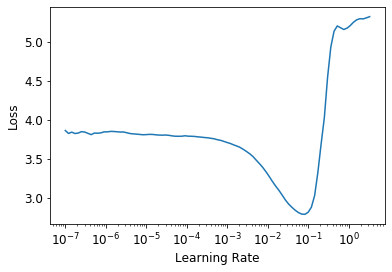

In [24]:
learn.lr_find()

In [25]:
learn.fit_one_cycle(1, lr_max=1e-2)

epoch,train_loss,valid_loss,error_rate,time
0,0.704656,0.333663,0.115020,00:13


In [26]:
learn.save('my_resnet18_finetuned')

**List of Learning Rates: last values of cosine annealing for the 1cycle policy with lr_max = 1e-2**

In [27]:
# Check the number of parameters groups...
print(f'number of parameters groups: {len(learn.opt.param_groups)}')

# ... and the list of Learning Rates (last values of cosine annealing for the 1cycle policy with lr_max = 1e-2)
for i,h in enumerate(learn.opt.hypers):
    print(i,h)

number of parameters groups: 10
0 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 5.281577479700553e-06, 'mom': 0.94994818370704, 'eps': 1e-05}
1 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 5.281577479700553e-06, 'mom': 0.94994818370704, 'eps': 1e-05}
2 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 5.281577479700553e-06, 'mom': 0.94994818370704, 'eps': 1e-05}
3 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 5.281577479700553e-06, 'mom': 0.94994818370704, 'eps': 1e-05}
4 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 5.281577479700553e-06, 'mom': 0.94994818370704, 'eps': 1e-05}
5 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 5.281577479700553e-06, 'mom': 0.94994818370704, 'eps': 1e-05}
6 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 5.281577479700553e-06, 'mom': 0.94994818370704, 'eps': 1e-05}
7 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 5.281577479700553e-06, 'mom': 0.94994818370704, 'eps': 1e-05}
8 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 5.281577479700553e-06, 'mom': 0.94994818370704, 'eps': 1e-05}
9 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 5.281577479700553e-06, 'mom': 

**Conclusion**

We can verify than the Learning Rates of all parameters groups are identical but only the last parameters group has been updated as the ```Learner``` was frozen.

### Test 1 | lr_max = 1e-3

**Hypothese**: all parameters groups with the same (max) Learning Rate (lr_max = 1e-3).

In [28]:
learn.load('my_resnet18_finetuned')
learn.unfreeze()

In [29]:
learn.fit_one_cycle(3, lr_max=1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.861377,3.378591,0.577808,00:16
1,0.615114,0.678442,0.223275,00:16
2,0.307324,0.321883,0.110284,00:16


**List of Learning Rates: last values of cosine annealing for the 1cycle policy with lr_max = 1e-3**

In [30]:
# Check the number of parameters groups...
print(f'number of parameters groups: {len(learn.opt.param_groups)}')

# ... and the list of Learning Rates (last values of cosine annealing for the 1cycle policy with lr_max = 1e-3)
for i,h in enumerate(learn.opt.hypers):
    print(i,h)

number of parameters groups: 10
0 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 6.758145103822125e-08, 'mom': 0.9499942417973141, 'eps': 1e-05}
1 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 6.758145103822125e-08, 'mom': 0.9499942417973141, 'eps': 1e-05}
2 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 6.758145103822125e-08, 'mom': 0.9499942417973141, 'eps': 1e-05}
3 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 6.758145103822125e-08, 'mom': 0.9499942417973141, 'eps': 1e-05}
4 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 6.758145103822125e-08, 'mom': 0.9499942417973141, 'eps': 1e-05}
5 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 6.758145103822125e-08, 'mom': 0.9499942417973141, 'eps': 1e-05}
6 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 6.758145103822125e-08, 'mom': 0.9499942417973141, 'eps': 1e-05}
7 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 6.758145103822125e-08, 'mom': 0.9499942417973141, 'eps': 1e-05}
8 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 6.758145103822125e-08, 'mom': 0.9499942417973141, 'eps': 1e-05}
9 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 6.7581451038

**Conclusion**

We can verify than the Learning Rates of all parameters groups are identical.

### Test 2 | lr_max = slice(1e-3)

**Hypothese**

- The last parameters group has a Learning Rate lr_max of 1e-3.
- All the (previous) others have a Learning Rate lr_max of **lr_max/10**.

In [31]:
learn.load('my_resnet18_finetuned')
learn.unfreeze()

In [32]:
learn.fit_one_cycle(3, lr_max=slice(1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.346102,0.320928,0.106901,00:16
1,0.242630,0.249166,0.086604,00:16
2,0.151128,0.233383,0.087957,00:16


**List of Learning Rates: last values of cosine annealing for the 1cycle policy with lr_max = slice(1e-3)**

In [33]:
# Check the number of parameters groups...
print(f'number of parameters groups: {len(learn.opt.param_groups)}')

# ... and the list of Learning Rates (last values of cosine annealing for the 1cycle policy with lr_max = slice(1e-3))
for i,h in enumerate(learn.opt.hypers):
    print(i,h)

number of parameters groups: 10
0 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 6.758145103824835e-09, 'mom': 0.9499942417973141, 'eps': 1e-05}
1 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 6.758145103824835e-09, 'mom': 0.9499942417973141, 'eps': 1e-05}
2 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 6.758145103824835e-09, 'mom': 0.9499942417973141, 'eps': 1e-05}
3 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 6.758145103824835e-09, 'mom': 0.9499942417973141, 'eps': 1e-05}
4 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 6.758145103824835e-09, 'mom': 0.9499942417973141, 'eps': 1e-05}
5 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 6.758145103824835e-09, 'mom': 0.9499942417973141, 'eps': 1e-05}
6 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 6.758145103824835e-09, 'mom': 0.9499942417973141, 'eps': 1e-05}
7 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 6.758145103824835e-09, 'mom': 0.9499942417973141, 'eps': 1e-05}
8 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 6.758145103824835e-09, 'mom': 0.9499942417973141, 'eps': 1e-05}
9 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 6.7581451038

**Conclusion**

- We can verify than the Learning Rates of the 9 first parameters groups are 10 times less than the one of the last parameters group.
- With a smaller Learning Rate for the parameters groups but the last one, the error rate is smaller than the test 1 (same Learning Rate for all parameters groups).

### Test 3 | lr_max = slice(1e-5,1e-3)

**Hypothese**

- Train first parameters group with lr_max = 1e-5 and last one with lr_max = 1e-3. 
- Between these 2 parameters groups, the Learning Rate (max) of the others are evenly geometrically spaced between 1e-5 and 1e-3.

In [34]:
learn.load('my_resnet18_finetuned')
learn.unfreeze()

In [35]:
learn.fit_one_cycle(3, lr_max=slice(1e-3/100,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.435387,0.542696,0.178620,00:17
1,0.306988,0.319851,0.106225,00:17
2,0.151053,0.234533,0.075778,00:16


**List of Learning Rates: last values of cosine annealing for the 1cycle policy with lr_max = slice(1e-5,1e-3)**

In [36]:
# Check the number of parameters groups...
print(f'number of parameters groups: {len(learn.opt.param_groups)}')

# ... and the list of Learning Rates (last values of cosine annealing for the 1cycle policy with lr_max = slice(1e-5,1e-3))
for i,h in enumerate(learn.opt.hypers):
    print(i,h)

number of parameters groups: 10
0 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 6.758145103818059e-10, 'mom': 0.9499942417973141, 'eps': 1e-05}
1 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 1.1273265478161222e-09, 'mom': 0.9499942417973141, 'eps': 1e-05}
2 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 1.880494020012536e-09, 'mom': 0.9499942417973141, 'eps': 1e-05}
3 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 3.1368530849825837e-09, 'mom': 0.9499942417973141, 'eps': 1e-05}
4 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 5.232586316170941e-09, 'mom': 0.9499942417973141, 'eps': 1e-05}
5 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 8.7284800449677e-09, 'mom': 0.9499942417973141, 'eps': 1e-05}
6 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 1.4559982251924255e-08, 'mom': 0.9499942417973141, 'eps': 1e-05}
7 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 2.428751421610113e-08, 'mom': 0.9499942417973141, 'eps': 1e-05}
8 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 4.051401551101539e-08, 'mom': 0.9499942417973141, 'eps': 1e-05}
9 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 6.758145103

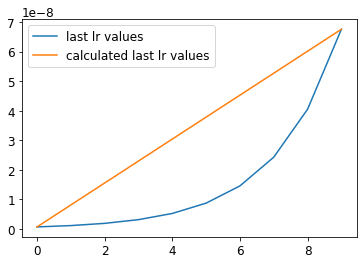

In [37]:
lr_list = list()
for h in learn.opt.hypers:
    lr_list.append(h['lr'])

lr_first = lr_list[0]
lr_last = lr_list[-1]
inter = (lr_last - lr_first) / (len(learn.opt.param_groups) - 1)
lr_list_calculated = [lr_first+i*inter for i in range(len(learn.opt.param_groups))]

fig, ax = plt.subplots()
p = np.linspace(0,9,10)
ax.plot(p, lr_list, label='last lr values')
ax.plot(p, lr_list_calculated,  label='calculated last lr values')
leg = ax.legend();

**Conclusion**

- We can verify that the Learning Rates of the parameters groups are **evenly geometrically spaced** (it does not mean linearly spaced) from the smallest value (first group) to the largest one (last group).
- With an incremental Learning Rate from the smallest to the highest value (each parameters groups with a different one), the error rate is smaller than the ones of the previous test 1 and 2.

### Test 4 | array of 10 learning rates | lr_max = [lr1,lr2,lr3,lr4,lr5,lr6,lr7,lr8,lr9,lr10]

Each parameters group has a Learning Rate different from the smallest to the highest value given by a list.

In [38]:
learn.load('my_resnet18_finetuned')
learn.unfreeze()

In [39]:
lr_lastlayer = 1e-3
lr_firstlayer = lr_lastlayer / 100
inter = (lr_lastlayer - lr_firstlayer) / (len(learn.opt.param_groups) - 1) # 9 intervals
lr_max = [lr_firstlayer + i*inter for i in range(len(learn.opt.param_groups) - 1)]
lr_max.append(lr_lastlayer)
len(lr_max), lr_max

(10,
 [1e-05,
  0.00012,
  0.00023,
  0.00034,
  0.00045000000000000004,
  0.0005600000000000001,
  0.00067,
  0.0007800000000000001,
  0.0008900000000000001,
  0.001])

In [40]:
learn.fit_one_cycle(3, lr_max=lr_max)

epoch,train_loss,valid_loss,error_rate,time
0,0.688318,1.270768,0.347091,00:16
1,0.501638,0.422770,0.140731,00:16
2,0.239655,0.272979,0.088633,00:16


**List of Learning Rates: last values of cosine annealing for the 1cycle policy with lr_max = [lr1,lr2,lr3,lr4,lr5,lr6,lr7,lr8,lr9,lr10]**

In [41]:
# Check the number of parameters groups...
print(f'number of parameters groups: {len(learn.opt.param_groups)}')

# ... and the list of Learning Rates (last values of cosine annealing for the 1cycle policy with lr_max = [lr1,lr2,lr3,lr4,lr5,lr6,lr7,lr8,lr9,lr10])
for i,h in enumerate(learn.opt.hypers):
    print(i,h)

number of parameters groups: 10
0 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 6.758145103818059e-10, 'mom': 0.9499942417973141, 'eps': 1e-05}
1 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 8.10977412458167e-09, 'mom': 0.9499942417973141, 'eps': 1e-05}
2 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 1.554373373877137e-08, 'mom': 0.9499942417973141, 'eps': 1e-05}
3 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 2.297769335300173e-08, 'mom': 0.9499942417973141, 'eps': 1e-05}
4 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 3.041165296717788e-08, 'mom': 0.9499942417973141, 'eps': 1e-05}
5 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 3.7845612581299815e-08, 'mom': 0.9499942417973141, 'eps': 1e-05}
6 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 4.527957219563859e-08, 'mom': 0.9499942417973141, 'eps': 1e-05}
7 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 5.271353180976053e-08, 'mom': 0.9499942417973141, 'eps': 1e-05}
8 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 6.014749142399089e-08, 'mom': 0.9499942417973141, 'eps': 1e-05}
9 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 6.7581451038

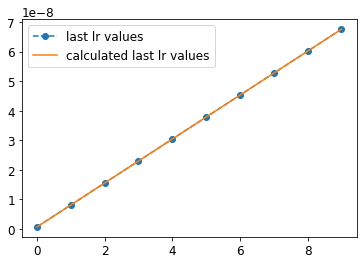

In [42]:
lr_list = list()
for h in learn.opt.hypers:
    lr_list.append(h['lr'])

lr_first = lr_list[0]
lr_last = lr_list[-1]
inter = (lr_last - lr_first) / (len(learn.opt.param_groups) - 1)
lr_list_calculated = [lr_first+i*inter for i in range(len(learn.opt.param_groups))]

fig, ax = plt.subplots()
p = np.linspace(0,9,10)
ax.plot(p, lr_list, 'o--', label='last lr values')
ax.plot(p, lr_list_calculated, label='calculated last lr values')
leg = ax.legend();

**Conclusion**
    
- We can verify that the Learning Rates of the groups of parameters are distributed linearly from the smallest value (first group) to the largest (last group) exactly as we passed them.
- However, the error rate is higher that the one of the test 3.

### Test 5 | array of 9 learning rates | lr_max = [lr1,lr2,lr3,lr4,lr5,lr6,lr7,lr8,lr9]

In [43]:
learn.load('my_resnet18_finetuned')
learn.unfreeze()

In [44]:
lr_lastlayer = 1e-3
lr_firstlayer = lr_lastlayer / 100
inter = (lr_lastlayer - lr_firstlayer) / ( len(learn.opt.param_groups) - 2 )  # 8 intervals
lr_max = [lr_firstlayer + i*inter for i in range(len(learn.opt.param_groups) - 2)]
lr_max.append(lr_lastlayer)
len(lr_max), lr_max

(9,
 [1e-05,
  0.00013375,
  0.0002575,
  0.00038125,
  0.000505,
  0.00062875,
  0.0007525,
  0.0008762500000000001,
  0.001])

In [45]:
learn.fit_one_cycle(3, lr_max=lr_max)

AssertionError: Trying to set 9 values for lr but there are 10 parameter groups.

**AssertionError Explication**: we can not pass an array of 9 learning rates because there are 10 parameters groups.

## END